# architecture-04

What's new:

1- https://chatgpt.com/c/6843cb51-89f0-800a-856a-f98e8790af81

    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        LSTM(32),
        Dense(FORECAST_HORIZON)
    ])



In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import talib
from tensorflow.keras import callbacks

In [5]:
df = pd.read_csv('datasets-04/XAGUSD-H1-rates.csv', sep='\t').dropna()

In [6]:
# Feature Engineering (TA-Lib indicators)
def add_ta_features(df):
    df['rsi'] = talib.RSI(df['<CLOSE>'], timeperiod=14)
    df['macd'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['<CLOSE>'])
    df['ema_10'] = talib.EMA(df['<CLOSE>'], timeperiod=10)
    df['ema_50'] = talib.EMA(df['<CLOSE>'], timeperiod=50)
    df['atr'] = talib.ATR(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    df['adx'] = talib.ADX(df['<HIGH>'], df['<LOW>'], df['<CLOSE>'], timeperiod=14)
    df = df.dropna()
    return df


df = add_ta_features(df)

In [7]:
# Scaling Features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(
    df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', 'rsi', 'macd', 'ema_10', 'ema_50', 'atr', 'adx']])

In [8]:
# Prepare sequences
def create_sequences(features, target, window, horizon):
    X, y = [], []
    for i in range(window, len(features) - horizon):
        X.append(features[i - window:i])
        y.append(target[i:i + horizon])
    return np.array(X), np.array(y)


WINDOW_SIZE = 60
FORECAST_HORIZON = 10


close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(df[['<CLOSE>']])
X, y = create_sequences(scaled, scaled_close, WINDOW_SIZE, FORECAST_HORIZON)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Build basic LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(FORECAST_HORIZON)
])

model.compile(optimizer='adam', loss='mse')

# Train
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train, y_train,
    epochs=50,
    verbose=1,
    callbacks=[es]
)

/home/saeed/repozitories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50


2025-06-07 12:23:24.817834: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 116083440 exceeds 10% of free system memory.


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 68s 46ms/step - loss: 0.0049
Epoch 2/50
   2/1375 ━━━━━━━━━━━━━━━━━━━━ 1:16 56ms/step - loss: 2.2010e-04

/home/saeed/repozitories/machine-learning/forex-prediction/envs/lib/python3.11/site-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


1375/1375 ━━━━━━━━━━━━━━━━━━━━ 75s 54ms/step - loss: 1.3987e-04
Epoch 3/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 60s 43ms/step - loss: 1.3290e-04
Epoch 4/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 59s 43ms/step - loss: 1.2745e-04
Epoch 5/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 60s 43ms/step - loss: 1.1203e-04
Epoch 6/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 59s 43ms/step - loss: 1.1800e-04
Epoch 7/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 73s 53ms/step - loss: 1.0270e-04
Epoch 8/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - loss: 1.0218e-04
Epoch 9/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 79s 58ms/step - loss: 1.0010e-04
Epoch 10/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 82s 59ms/step - loss: 9.7008e-05
Epoch 11/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - loss: 9.7322e-05
Epoch 12/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - loss: 9.5012e-05
Epoch 13/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 85s 62ms/step - loss: 9.4336e-05
Epoch 14/50
1375/1375 ━━━━━━━━━━━━━━━━━━━━ 90s 65ms/step - loss: 9.2732e-05
Epoch 15/50
1375/1375 ━━━━━━━━━

In [10]:
# === Load the last 60 rows from a separate CSV file for prediction ===
input_df = pd.read_csv('datasets-04/new-data-for-test/rows-60-from-20240503/rows-60-from-20240503.csv',
                       sep='\t').dropna()
input_df = add_ta_features(input_df)
input_scaled = scaler.transform(
    input_df[['<OPEN>', '<HIGH>', '<LOW>', '<CLOSE>', '<TICKVOL>', 'rsi', 'macd', 'ema_10', 'ema_50', 'atr', 'adx']])
input_sequence = np.expand_dims(input_scaled, axis=0)  # shape: (1, 60, 5)

# === Predict the next 10 candles + Inverse scale ===
pred = model.predict(input_sequence)
prediction = close_scaler.inverse_transform(pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


# plot section

In [13]:
import sys

sys.path.insert(1, '../utils')
import forex_plot_utils
import os

# PARAMETERS
csv1_path = 'datasets-04/new-data-for-test/rows-60-from-20240503/latest-4-for-history.csv'
csv3_path = 'datasets-04/new-data-for-test/rows-60-from-20240503/after.csv'
plot_title = 'Actual vs Predicted Forex Closing Prices'
output_plot_path = None  # e.g., 'output.png'

# LOAD DATA FROM CSVS
historical_df = forex_plot_utils.load_csv_with_datetime(csv1_path) if os.path.exists(csv1_path) else None
actual_future_df = forex_plot_utils.load_csv_with_datetime(csv3_path) if os.path.exists(csv3_path) else None

# LOAD DATA FROM PREDICTION

# Combine <DATE> and <TIME> columns into a datetime
input_df['DATETIME'] = pd.to_datetime(input_df['<DATE>'] + ' ' + input_df['<TIME>'])

last_timestamp = input_df['DATETIME'].iloc[-1]
datetime_index = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(prediction[0]), freq='h')

# Create DataFrame
predicted_df = pd.DataFrame({'DATETIME': datetime_index, '<CLOSE>': prediction[0]})

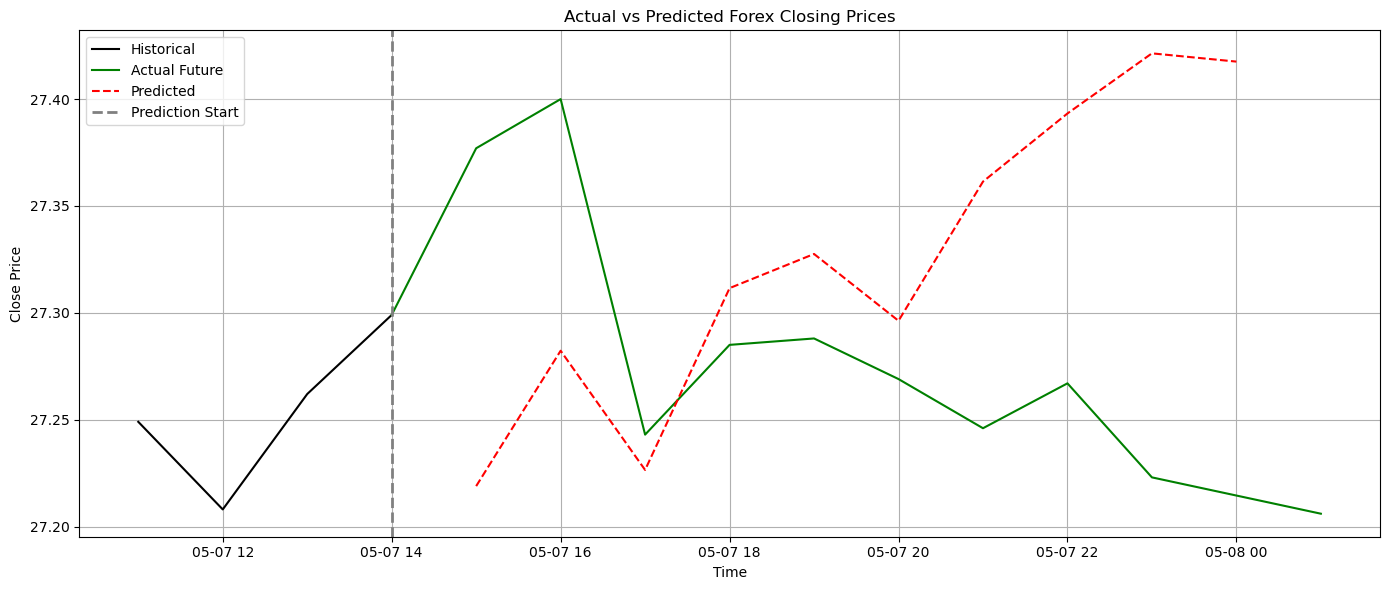

In [14]:
# PLOT
forex_plot_utils.plot_all_series(
    historical_df=historical_df,
    predicted_df=predicted_df,
    actual_future_df=actual_future_df,
    title=plot_title,
    output_path=output_plot_path
)

In [15]:
from datetime import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt

# === Create timestamp and paths ===
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
model_filename = f'model_{timestamp}.keras'
model_path = os.path.join('saved_models', model_filename)

# Directory to hold logs and extras
log_dir = os.path.join('saved_models', f'model_{timestamp}_logs')
os.makedirs(log_dir, exist_ok=True)

# === Save model ===
model.save(model_path)

# === Save training history ===
history_df = pd.DataFrame(history.history)
history_df.to_csv(os.path.join(log_dir, 'training_history.csv'), index=False)

# === Save training loss plot ===
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(log_dir, 'training_loss.png'))
plt.close()

# === Save model summary and final performance ===
with open(os.path.join(log_dir, 'model_log.txt'), 'w') as f:
    model.summary(print_fn=lambda x: f.write(x + '\n'))
    final_train_loss = history.history['loss'][-1]
    final_test_loss = model.evaluate(X_test, y_test, verbose=0)
    f.write(f'\nFinal Training Loss: {final_train_loss:.6f}\n')
    f.write(f'Final Test Loss: {final_test_loss:.6f}\n')
